Dataset Shape: (569, 31)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Target meaning: 0 = Malignant, 1 = Benign
Training set size: (398, 30)
Test set size: (171, 30)

MODEL EVALUATION METRICS:
Accuracy:  0.9883
Precision: 0.9907
Recall:    0.9907
F1-Score:  0.9907
ROC-AUC:   0.9981


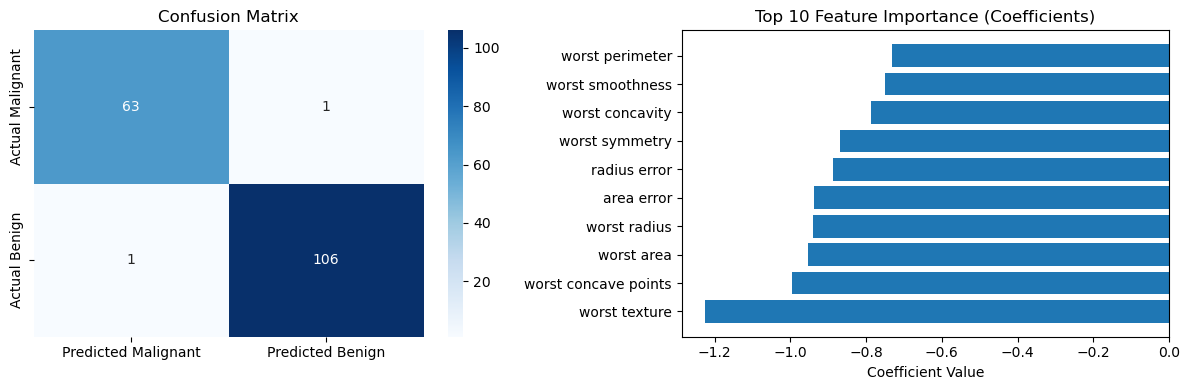

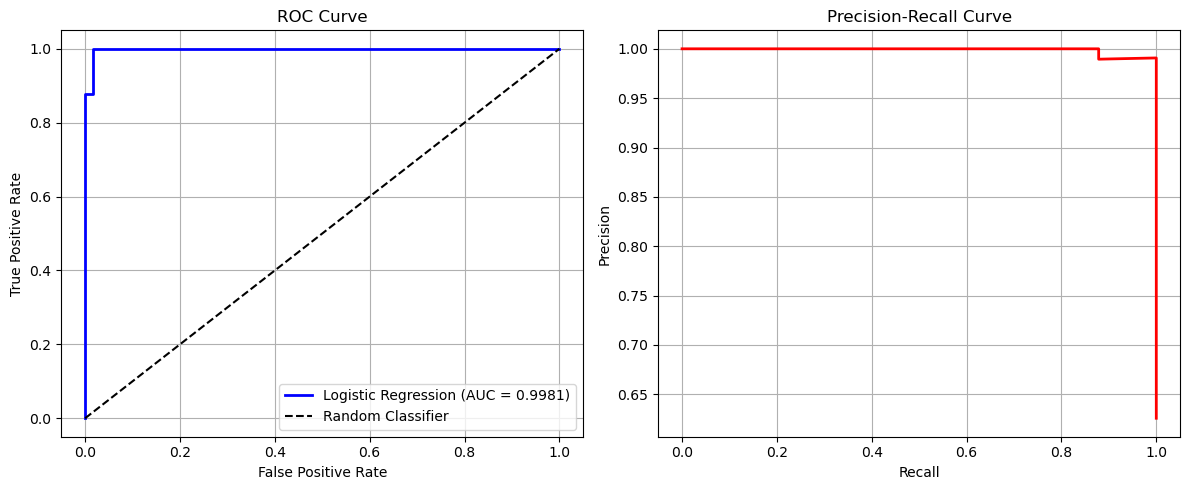

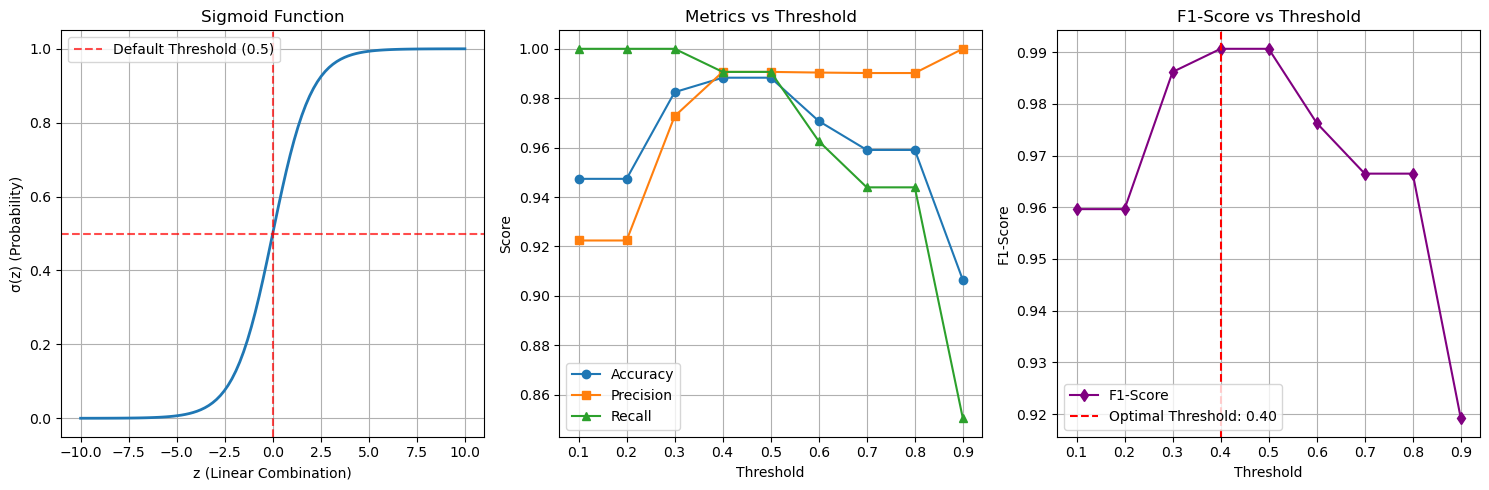


Optimal Threshold: 0.40
F1-Score at optimal threshold: 0.9907

Performance with optimal threshold (0.40):
Accuracy:  0.9883
Precision: 0.9907
Recall:    0.9907
F1-Score:  0.9907

MODEL INTERPRETATION

1. SIGMOID FUNCTION:
   - Converts linear combination to probability between 0 and 1
   - σ(z) = 1 / (1 + e^(-z)) where z = w·x + b
   - Default classification threshold: 0.5

2. KEY COEFFICIENTS (Top 5):
   - worst texture            :  -1.226 (decreases probability of malignancy)
   - worst concave points     :  -0.997 (decreases probability of malignancy)
   - worst area               :  -0.955 (decreases probability of malignancy)
   - worst radius             :  -0.941 (decreases probability of malignancy)
   - area error               :  -0.937 (decreases probability of malignancy)

3. BUSINESS IMPLICATIONS:
   - High recall is crucial (minimize false negatives - missing cancer)
   - Precision-Recall tradeoff depends on application requirements
   - Current model detects 99.1% of a

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                           precision_score, recall_score, f1_score, roc_curve, 
                           roc_auc_score, precision_recall_curve)
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

# Create DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Display basic information
print("Dataset Shape:", df.shape)
print("\nTarget distribution:")
print(df['target'].value_counts())
print("\nTarget meaning: 0 = Malignant, 1 = Benign")

# Prepare features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("\nMODEL EVALUATION METRICS:")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc_roc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Malignant', 'Predicted Benign'],
            yticklabels=['Actual Malignant', 'Actual Benign'])
plt.title('Confusion Matrix')

# Feature Importance
plt.subplot(1, 2, 2)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': logreg.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False).head(10)

plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importance (Coefficients)')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall Curves
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'Logistic Regression (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='red', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

plt.tight_layout()
plt.show()

# Sigmoid Function Demonstration
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x_values = np.linspace(-10, 10, 100)
y_sigmoid = sigmoid(x_values)

plt.figure(figsize=(15, 5))

# Sigmoid Function
plt.subplot(1, 3, 1)
plt.plot(x_values, y_sigmoid, linewidth=2)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Default Threshold (0.5)')
plt.xlabel('z (Linear Combination)')
plt.ylabel('σ(z) (Probability)')
plt.title('Sigmoid Function')
plt.grid(True)
plt.legend()

# Threshold tuning analysis
thresholds = np.arange(0.1, 1.0, 0.1)
accuracy_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    accuracy_scores.append(accuracy_score(y_test, y_pred_custom))
    precision_scores.append(precision_score(y_test, y_pred_custom))
    recall_scores.append(recall_score(y_test, y_pred_custom))

plt.subplot(1, 3, 2)
plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='o')
plt.plot(thresholds, precision_scores, label='Precision', marker='s')
plt.plot(thresholds, recall_scores, label='Recall', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)

# Find optimal threshold (maximizing F1-score)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_scores, recall_scores)]
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.subplot(1, 3, 3)
plt.plot(thresholds, f1_scores, label='F1-Score', marker='d', color='purple')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', 
            label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"F1-Score at optimal threshold: {f1_scores[optimal_idx]:.4f}")

# Compare performance with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print(f"\nPerformance with optimal threshold ({optimal_threshold:.2f}):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_optimal):.4f}")

# Model interpretation
print("\n" + "=" * 60)
print("MODEL INTERPRETATION")
print("=" * 60)

print("\n1. SIGMOID FUNCTION:")
print("   - Converts linear combination to probability between 0 and 1")
print("   - σ(z) = 1 / (1 + e^(-z)) where z = w·x + b")
print("   - Default classification threshold: 0.5")

print("\n2. KEY COEFFICIENTS (Top 5):")
top_features = feature_importance.head(5)
for idx, row in top_features.iterrows():
    effect = "increases probability of malignancy" if row['coefficient'] > 0 else "decreases probability of malignancy"
    print(f"   - {row['feature']:25}: {row['coefficient']:7.3f} ({effect})")

print("\n3. BUSINESS IMPLICATIONS:")
print("   - High recall is crucial (minimize false negatives - missing cancer)")
print("   - Precision-Recall tradeoff depends on application requirements")
print(f"   - Current model detects {recall*100:.1f}% of actual malignant cases")
print(f"   - {precision*100:.1f}% of predicted malignant cases are truly malignant")